In [34]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
path = str(Path.cwd().parent)
print(path)
sys.path.insert(1, path)

import numpy as np
import pandas as pd
import skforecast

print(skforecast.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
c:\Users\jaesc2\GitHub\skforecast
0.20.0


In [38]:
import re
import pytest
import numpy as np
import pandas as pd
from skforecast.stats import Sarimax, Arar, Ets, Arima
from skforecast.recursive import ForecasterStats
from skforecast.model_selection._split import TimeSeriesFold
from skforecast.model_selection import backtesting_stats
from skforecast.model_selection._validation import _backtesting_stats
from skforecast.plot import set_dark_theme
from skforecast.datasets import fetch_dataset
import matplotlib.pyplot as plt
from skforecast.stats.arima._arima_base import arima
from skforecast.stats.arima._auto_arima import auto_arima, fit_custom_arima

from aeon.forecasting.stats import ARIMA as AeonARIMA

# Fixtures
from skforecast.stats.tests.tests_arima.fixtures_arima import air_passengers, multi_seasonal, fuel_consumption
from skforecast.recursive.tests.tests_forecaster_stats.fixtures_forecaster_stats import y_datetime
from skforecast.recursive.tests.tests_forecaster_stats.fixtures_forecaster_stats import exog_datetime

In [9]:
import time
import platform
import psutil
import threadpoolctl

%load_ext pyinstrument
%load_ext line_profiler

Train dates : 1969-01-01 00:00:00 --- 1980-01-01 00:00:00  (n=133)
Test dates  : 1980-02-01 00:00:00 --- 1990-01-01 00:00:00  (n=120)


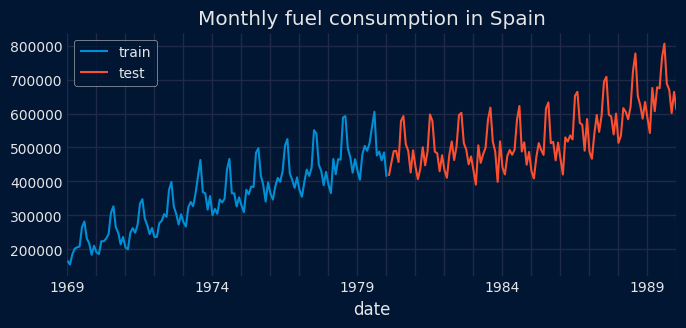

In [3]:
# Download data
# ==============================================================================
data = fetch_dataset(name='fuel_consumption', raw=True, verbose=False)
data = data[['Fecha', 'Gasolinas']]
data = data.rename(columns={'Fecha': 'date', 'Gasolinas': 'y'})
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('MS')
data = data.loc[:'1990-01-01 00:00:00', ['y']]
data['month'] = data.index.month
data = pd.get_dummies(data, columns=['month'], prefix='month', drop_first=False, dtype=float)
data.head(3)

# Train-test dates
# ======================================================================================
set_dark_theme()
end_train = '1980-01-01 23:59:59'
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  "
    f"(n={len(data.loc[:end_train])})"
)
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.loc[:].index.max()}  "
    f"(n={len(data.loc[end_train:])})"
)
data_train = data.loc[:end_train]
data_test  = data.loc[end_train:]

# Plot
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.set_title('Monthly fuel consumption in Spain')
ax.legend();

In [4]:
estimator_list = [
    Arima(
        order=(1, 1, 1),
        seasonal_order=(1, 1, 1),
        m = 12
    ),
    Arima(
        order=(1, 2, 1),
        seasonal_order=(1, 1, 1),
        m = 12
    ),
    Sarimax(
        order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), maxiter=1000, method='cg', disp=False
    ),
    Ets(),
    Arar(),
    # AeonARIMA(p=1, d=1, q=1)
]
# estimator_list = Arima(
#         order=(1, 1, 1),
#         seasonal_order=(1, 1, 1),
#         m = 12
#     )
estimator_list = [
    Arima(
        order=None,
        seasonal_order=None,
        m = 12
    ),
    Arar(),
    # AeonARIMA(p=1, d=1, q=1)
]

forecaster = ForecasterStats(estimator=estimator_list)
forecaster.fit(
    y=data_train['y'],
    exog=data_train.drop(columns=['y']),
    suppress_warnings=True
)
preds = forecaster.predict(steps=12, exog=data_test.drop(columns=['y']))
preds.head(3)

,estimator_id,pred
1980-02-01,skforecast.Arima,291223.560446
1980-02-01,skforecast.Arar,412108.420405
1980-03-01,skforecast.Arima,366695.262521


In [5]:
preds = forecaster.predict_interval(steps=12, exog=data_test.drop(columns=['y']))
preds

,estimator_id,pred,lower_bound,upper_bound
1980-02-01,skforecast.Arima,291223.560446,159726.721428,422720.399463
1980-02-01,skforecast.Arar,412108.420405,383429.968583,440786.872228
1980-03-01,skforecast.Arima,366695.262521,201602.826391,531787.698651
1980-03-01,skforecast.Arar,457131.211792,425528.529817,488733.893767
1980-04-01,skforecast.Arima,418096.831360,225172.995967,611020.666752
1980-04-01,skforecast.Arar,480106.339597,442458.575261,517754.103932
1980-05-01,skforecast.Arima,388387.138263,171169.044961,605605.231565
1980-05-01,skforecast.Arar,476978.725255,436033.299448,517924.151063
1980-06-01,skforecast.Arima,453791.772440,214733.189602,692850.355277
1980-06-01,skforecast.Arar,484686.057130,440092.547845,529279.566414


In [30]:
estimator_list = [
    Arima(
        order=None,
        seasonal_order=None,
        m = 12
    ),
    # Arar(),
]

forecaster = ForecasterStats(estimator=estimator_list)

In [31]:
cv = TimeSeriesFold(
            steps                 = 10,
            initial_train_size    = len(data_train),
            refit                 = True,
            fixed_train_size      = False,
            gap                   = 0,
            allow_incomplete_fold = True
        )

metric, backtest_predictions = backtesting_stats(
                                    forecaster = forecaster,
                                    y          = data['y'],
                                    cv         = cv,
                                    freeze_params=False,
                                    metric     = ['mean_squared_error', 'mean_absolute_error'],
                                    alpha      = None,
                                    interval   = None,
                                    n_jobs     = 1,
                                    verbose    = False,
                                    suppress_warnings=True
                                )

  0%|          | 0/12 [00:00<?, ?it/s]

In [28]:
backtest_predictions.groupby('fold')['estimator_id'].nunique()

fold
0     2
1     2
2     2
3     2
4     2
5     2
6     2
7     2
8     2
9     2
10    2
11    2
Name: estimator_id, dtype: int64

In [29]:
backtest_predictions

,fold,estimator_id,pred,estimator_params
1980-02-01,0,skforecast.Arima,418563.683585,"AutoArima(2,0,0)(0,1,2)[12]"
1980-02-01,0,skforecast.Arar,417947.645080,"AutoArima(2,0,0)(0,1,2)[12]"
1980-03-01,0,skforecast.Arima,491713.460647,"AutoArima(2,0,0)(0,1,2)[12]"
1980-03-01,0,skforecast.Arar,498325.568939,"AutoArima(2,0,0)(0,1,2)[12]"
1980-04-01,0,skforecast.Arima,496645.682873,"AutoArima(2,0,0)(0,1,2)[12]"
...,...,...,...,...
1989-11-01,11,skforecast.Arar,617807.050197,"Arar(lags=(1, 2, 12, 14))"
1989-12-01,11,skforecast.Arima,680116.318846,"Arar(lags=(1, 2, 12, 14))"
1989-12-01,11,skforecast.Arar,669662.281322,"Arar(lags=(1, 2, 12, 14))"
1990-01-01,11,skforecast.Arima,615117.009967,"Arar(lags=(1, 2, 12, 14))"


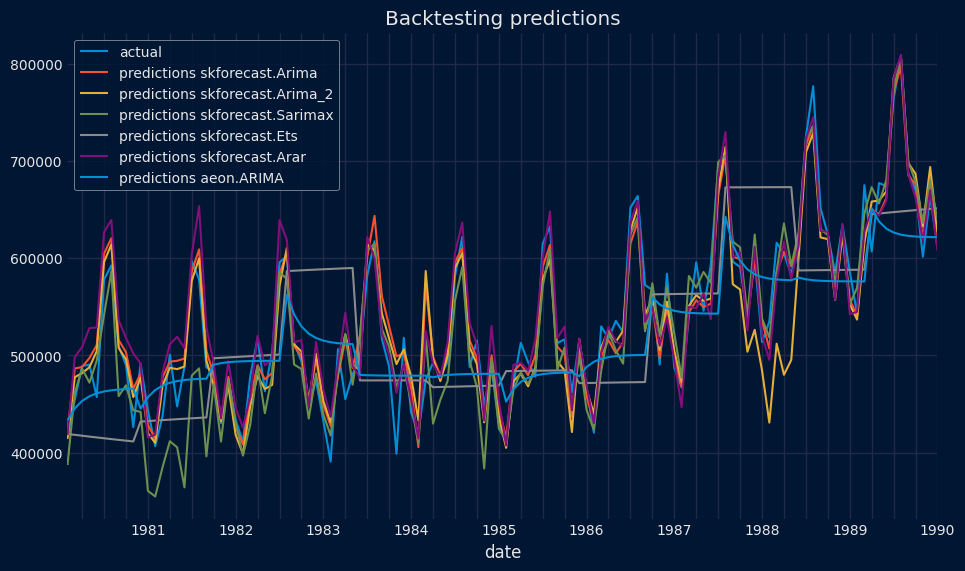

In [49]:
fig, ax = plt.subplots(figsize=(10, 6))
data_test['y'].plot(ax=ax, label='actual')
for est in backtest_predictions['estimator_id'].unique():
    preds = backtest_predictions.loc[
        backtest_predictions['estimator_id'] == est, 'pred'
    ]
    preds.plot(ax=ax, label=f'predictions {est}')
ax.set_title('Backtesting predictions')
ax.legend();

In [10]:
metric

,estimator_id,mean_squared_error,mean_absolute_error
0,skforecast.Arima,5.419326e+08,18036.944169
1,skforecast.Arar,8.396879e+08,22099.926509


In [16]:
y = data['y']
exog = None
cv = TimeSeriesFold(
            steps                 = 25,
            initial_train_size    = len(data_train),
            refit                 = True,
            fixed_train_size      = False,
            gap                   = 0,
            allow_incomplete_fold = True
        )


def funt_to_profile(forecaster, y, exog, cv):
   
    _backtesting_stats(
        forecaster = forecaster,
        y          = y,
        cv         = cv,
        freeze_params=False,
        metric     = ['mean_squared_error', 'mean_absolute_error'],
        alpha      = None,
        interval   = None,
        n_jobs     = 1,
        verbose    = False,
        suppress_warnings=True
    )


%lprun -f _backtesting_stats funt_to_profile(forecaster, y, exog, cv)

  0%|          | 0/5 [00:00<?, ?it/s]

Timer unit: 1e-07 s

Total time: 56.5043 s
File: c:\Users\jaesc2\GitHub\skforecast\skforecast\model_selection\_validation.py
Function: _backtesting_stats at line 1378

Line #      Hits         Time  Per Hit   % Time  Line Contents
  1378                                           def _backtesting_stats(
  1379                                               forecaster: object,
  1380                                               y: pd.Series,
  1381                                               cv: TimeSeriesFold,
  1382                                               metric: str | Callable | list[str | Callable],
  1383                                               exog: pd.Series | pd.DataFrame | None = None,
  1384                                               alpha: float | None = None,
  1385                                               interval: list[float] | tuple[float] | None = None,
  1386                                               freeze_params: bool = True,
  1387           

In [27]:
y = data_train['y']
exog = data_train.drop(columns=['y'])
estimator_list = [
    Arima(
        order=None,
        seasonal_order=None,
        m = 12
    ),
    Arar()
]
forecaster = ForecasterStats(estimator=estimator_list)


def funt_to_profile(forecaster, y, exog):
   
    forecaster.fit(
        y=y,
        exog=exog,
        suppress_warnings=True
    )


%lprun -f forecaster.fit funt_to_profile(forecaster, y, exog)

Timer unit: 1e-07 s

Total time: 5.62156 s
File: c:\Users\jaesc2\GitHub\skforecast\skforecast\recursive\_forecaster_stats.py
Function: ForecasterStats.fit at line 645

Line #      Hits         Time  Per Hit   % Time  Line Contents
   645                                               def fit(
   646                                                   self,
   647                                                   y: pd.Series,
   648                                                   exog: pd.Series | pd.DataFrame | None = None,
   649                                                   store_last_window: bool = True,
   650                                                   suppress_warnings: bool = False
   651                                               ) -> None:
   652                                                   """
   653                                                   Training Forecaster.
   654                                           
   655                                 

In [19]:
y = data_train['y']
exog = data_train.drop(columns=['y'])
estimator = Arima(
        order=None,
        seasonal_order=None,
        m = 12
    )


def funt_to_profile(estimator, y, exog):
   
    estimator.fit(
        y=y,
        exog=exog,
        suppress_warnings=True
    )


%lprun -f estimator.fit funt_to_profile(estimator, y, exog)

Timer unit: 1e-07 s

Total time: 4.10696 s
File: c:\Users\jaesc2\GitHub\skforecast\skforecast\stats\_arima.py
Function: Arima.fit at line 420

Line #      Hits         Time  Per Hit   % Time  Line Contents
   420                                               def fit(
   421                                                   self, 
   422                                                   y: np.ndarray | pd.Series, 
   423                                                   exog: np.ndarray | pd.Series | pd.DataFrame | None = None,
   424                                                   suppress_warnings: bool = False
   425                                               ) -> "Arima":
   426                                                   """
   427                                                   Fit the ARIMA model to a univariate time series.
   428                                           
   429                                                   If `order` or `seasonal_order` were n

In [21]:
y = data_train['y']
exog = data_train.drop(columns=['y'])
estimator = Arima(
        order=None,
        seasonal_order=None,
        m = 12
    )


def funt_to_profile(y, exog):
   
    auto_arima(
        y                  = y,
        m                  = estimator.m,
        d                  = estimator.order[1] if estimator.order is not None else None,
        D                  = estimator.seasonal_order[1] if estimator.seasonal_order is not None else None,
        max_p              = estimator.max_p,
        max_q              = estimator.max_q,
        max_P              = estimator.max_P,
        max_Q              = estimator.max_Q,
        max_order          = estimator.max_order,
        max_d              = estimator.max_d,
        max_D              = estimator.max_D,
        start_p            = estimator.start_p,
        start_q            = estimator.start_q,
        start_P            = estimator.start_P,
        start_Q            = estimator.start_Q,
        stationary         = estimator.stationary,
        seasonal           = estimator.seasonal,
        ic                 = estimator.ic,
        stepwise           = estimator.stepwise,
        nmodels            = estimator.nmodels,
        trace              = estimator.trace,
        approximation      = estimator.approximation,
        method             = estimator.method,
        truncate           = estimator.truncate,
        xreg               = exog,
        test               = estimator.test,
        test_args          = estimator.test_kwargs,
        seasonal_test      = estimator.seasonal_test,
        seasonal_test_args = estimator.seasonal_test_kwargs,
        allowdrift         = estimator.allowdrift,
        allowmean          = estimator.allowmean,
        lambda_bc          = estimator.lambda_bc,
        biasadj            = estimator.biasadj,
        SSinit             = estimator.SSinit,
        kappa              = estimator.kappa
    )


%lprun -f auto_arima funt_to_profile(y, exog)

c:\Users\jaesc2\GitHub\skforecast\skforecast\stats\arima\_arima_base.py:2509: UserWarning: Possible convergence problem.Try to increase 'maxiter' or change the optimization method.
  warnings.warn(
c:\Users\jaesc2\GitHub\skforecast\skforecast\stats\arima\_arima_base.py:2509: UserWarning: Possible convergence problem.Try to increase 'maxiter' or change the optimization method.
  warnings.warn(
c:\Users\jaesc2\GitHub\skforecast\skforecast\stats\arima\_arima_base.py:2509: UserWarning: Possible convergence problem.Try to increase 'maxiter' or change the optimization method.
  warnings.warn(
c:\Users\jaesc2\GitHub\skforecast\skforecast\stats\arima\_arima_base.py:2509: UserWarning: Possible convergence problem.Try to increase 'maxiter' or change the optimization method.
  warnings.warn(
c:\Users\jaesc2\GitHub\skforecast\skforecast\stats\arima\_arima_base.py:2509: UserWarning: Possible convergence problem.Try to increase 'maxiter' or change the optimization method.
  warnings.warn(
c:\Users\j

Timer unit: 1e-07 s

Total time: 3.87612 s
File: c:\Users\jaesc2\GitHub\skforecast\skforecast\stats\arima\_auto_arima.py
Function: auto_arima at line 735

Line #      Hits         Time  Per Hit   % Time  Line Contents
   735                                           def auto_arima(
   736                                               y: np.ndarray,
   737                                               m: int = 1,
   738                                               d: Optional[int] = None,
   739                                               D: Optional[int] = None,
   740                                               max_p: int = 5,
   741                                               max_q: int = 5,
   742                                               max_P: int = 2,
   743                                               max_Q: int = 2,
   744                                               max_order: int = 5,
   745                                               max_d: int = 2,
   746    

In [23]:
y = data_train['y']
exog = data_train.drop(columns=['y'])
estimator = Arima(
        order=None,
        seasonal_order=None,
        m = 12
    )


def funt_to_profile(y, exog):
   
    fit_custom_arima(
        x            = y.to_numpy(),
        m            = estimator.m,
        order        = (1, 1, 1),
        seasonal     = (1, 1, 1),
        constant     = True,
        ic           = estimator.ic,
        trace        = estimator.trace,
        approximation = estimator.approximation,
        offset       = 0.0,
        xreg         = exog,
        method       = estimator.method,
        nstar        = None
    )


%lprun -f fit_custom_arima funt_to_profile(y, exog)

c:\Users\jaesc2\GitHub\skforecast\skforecast\stats\arima\_arima_base.py:2509: UserWarning: Possible convergence problem.Try to increase 'maxiter' or change the optimization method.
  warnings.warn(


Timer unit: 1e-07 s

Total time: 1.30821 s
File: c:\Users\jaesc2\GitHub\skforecast\skforecast\stats\arima\_auto_arima.py
Function: fit_custom_arima at line 314

Line #      Hits         Time  Per Hit   % Time  Line Contents
   314                                           def fit_custom_arima(
   315                                               x: np.ndarray,
   316                                               m: int,
   317                                               order: Tuple[int, int, int] = (0, 0, 0),
   318                                               seasonal: Tuple[int, int, int] = (0, 0, 0),
   319                                               constant: bool = True,
   320                                               ic: str = "aic",
   321                                               trace: bool = False,
   322                                               approximation: bool = False,
   323                                               offset: float = 0.0,
   324   

In [25]:
y = data_train['y']
exog = data_train.drop(columns=['y'])
estimator = Arima(
        order=None,
        seasonal_order=None,
        m = 12
    )


def funt_to_profile(y, exog):
   
    arima(
        x              = y.to_numpy(),
        m              = estimator.m,
        order          = (1, 1, 1),
        seasonal       = (1, 1, 1),
        xreg           = exog,
        include_mean   = True,
        transform_pars = True,
        fixed          = None,
        init           = None,
        method         = "CSS-ML",
        n_cond         = None,
        SSinit         = estimator.SSinit,
        optim_method   = "BFGS",
        opt_options    = {'maxiter': 1000},
        kappa          = estimator.kappa
    )


%lprun -f arima funt_to_profile(y, exog)

c:\Users\jaesc2\GitHub\skforecast\skforecast\stats\arima\_arima_base.py:2509: UserWarning: Possible convergence problem.Try to increase 'maxiter' or change the optimization method.
  warnings.warn(


Timer unit: 1e-07 s

Total time: 1.26543 s
File: c:\Users\jaesc2\GitHub\skforecast\skforecast\stats\arima\_arima_base.py
Function: arima at line 2168

Line #      Hits         Time  Per Hit   % Time  Line Contents
  2168                                           def arima(
  2169                                               x: np.ndarray,
  2170                                               m: int = 1,
  2171                                               order: Tuple[int, int, int] = (0, 0, 0),
  2172                                               seasonal: Tuple[int, int, int] = (0, 0, 0),
  2173                                               xreg: Union[pd.DataFrame, np.ndarray, None] = None,
  2174                                               include_mean: bool = True,
  2175                                               transform_pars: bool = True,
  2176                                               fixed: Optional[np.ndarray] = None,
  2177                                        

In [32]:
air_passengers = pd.Series(np.array([
    112, 118, 132, 129, 121, 135, 148, 148, 136, 119, 104, 118,
    115, 126, 141, 135, 125, 149, 170, 170, 158, 133, 114, 140,
    145, 150, 178, 163, 172, 178, 199, 199, 184, 162, 146, 166,
    171, 180, 193, 181, 183, 218, 230, 242, 209, 191, 172, 194,
    196, 196, 236, 235, 229, 243, 264, 272, 237, 211, 180, 201,
    204, 188, 235, 227, 234, 264, 302, 293, 259, 229, 203, 229,
    242, 233, 267, 269, 270, 315, 364, 347, 312, 274, 237, 278,
    284, 277, 317, 313, 318, 374, 413, 405, 355, 306, 271, 306,
    315, 301, 356, 348, 355, 422, 465, 467, 404, 347, 305, 336,
    340, 318, 362, 348, 363, 435, 491, 505, 404, 359, 310, 337,
    360, 342, 406, 396, 420, 472, 548, 559, 463, 407, 362, 405,
    417, 391, 419, 461, 472, 535, 622, 606, 508, 461, 390, 432], dtype=np.float64),
    name="air_passengers"
)

In [33]:
len(air_passengers)

144

In [47]:
model = Arima(
        order=(2, 1, 1),
        seasonal_order=(1, 1, 1),
        m=1,
        optim_method="L-BFGS-B"
    )
model.fit(multi_seasonal, suppress_warnings=False)

,order,"(2, ...)"
,seasonal_order,"(1, ...)"
,m,1
,include_mean,True
,transform_pars,True
,method,'CSS-ML'
,n_cond,None
,SSinit,'Gardner1980'
,optim_method,'L-BFGS-B'
,optim_kwargs,{'maxiter': 1000}
,kappa,1000000.0
